In [1]:
#!pip install scipy==1.6.3


In [2]:
#!pip install numpy==1.19.3


In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE 
from tensorflow.keras.callbacks import ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_data = pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv", engine = 'python')

In [5]:
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


Text(0, 0.5, 'Counts')

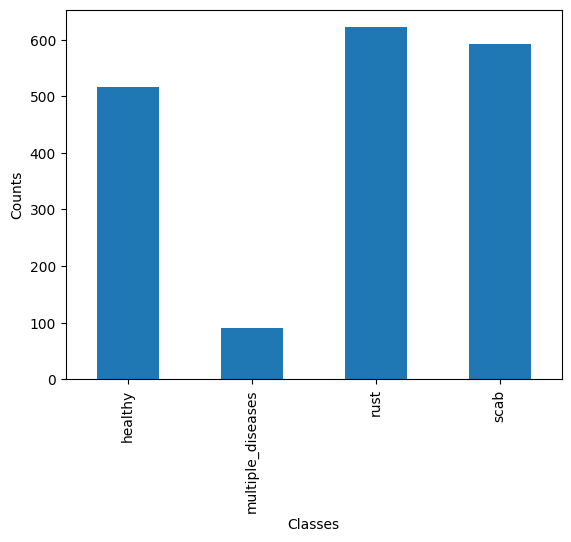

In [6]:
train_data.drop(columns=['image_id']).sum().plot.bar()
plt.xlabel("Classes")
plt.ylabel('Counts')

In [7]:
height = 1365
width = 2048
color_channels = 3
new_height = 224
new_width = 224

In [8]:
images = np.ndarray(shape=(len(train_data), new_height, new_width, color_channels), dtype=np.float32)

In [9]:
for i in range(len(train_data)):
    print("Image: " + str(i))
    image = tf.keras.preprocessing.image.load_img("../input/plant-pathology-2020-fgvc7/images/"+train_data['image_id'].iloc[i]+'.jpg')
    image = image.resize((new_width, new_height))
    image = tf.keras.preprocessing.image.img_to_array(image)
    print(image.shape)
    images[i] = image

Image: 0
(224, 224, 3)
Image: 1
(224, 224, 3)
Image: 2
(224, 224, 3)
Image: 3
(224, 224, 3)
Image: 4
(224, 224, 3)
Image: 5
(224, 224, 3)
Image: 6
(224, 224, 3)
Image: 7
(224, 224, 3)
Image: 8
(224, 224, 3)
Image: 9
(224, 224, 3)
Image: 10
(224, 224, 3)
Image: 11
(224, 224, 3)
Image: 12
(224, 224, 3)
Image: 13
(224, 224, 3)
Image: 14
(224, 224, 3)
Image: 15
(224, 224, 3)
Image: 16
(224, 224, 3)
Image: 17
(224, 224, 3)
Image: 18
(224, 224, 3)
Image: 19
(224, 224, 3)
Image: 20
(224, 224, 3)
Image: 21
(224, 224, 3)
Image: 22
(224, 224, 3)
Image: 23
(224, 224, 3)
Image: 24
(224, 224, 3)
Image: 25
(224, 224, 3)
Image: 26
(224, 224, 3)
Image: 27
(224, 224, 3)
Image: 28
(224, 224, 3)
Image: 29
(224, 224, 3)
Image: 30
(224, 224, 3)
Image: 31
(224, 224, 3)
Image: 32
(224, 224, 3)
Image: 33
(224, 224, 3)
Image: 34
(224, 224, 3)
Image: 35
(224, 224, 3)
Image: 36
(224, 224, 3)
Image: 37
(224, 224, 3)
Image: 38
(224, 224, 3)
Image: 39
(224, 224, 3)
Image: 40
(224, 224, 3)
Image: 41
(224, 224, 3)
Im

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

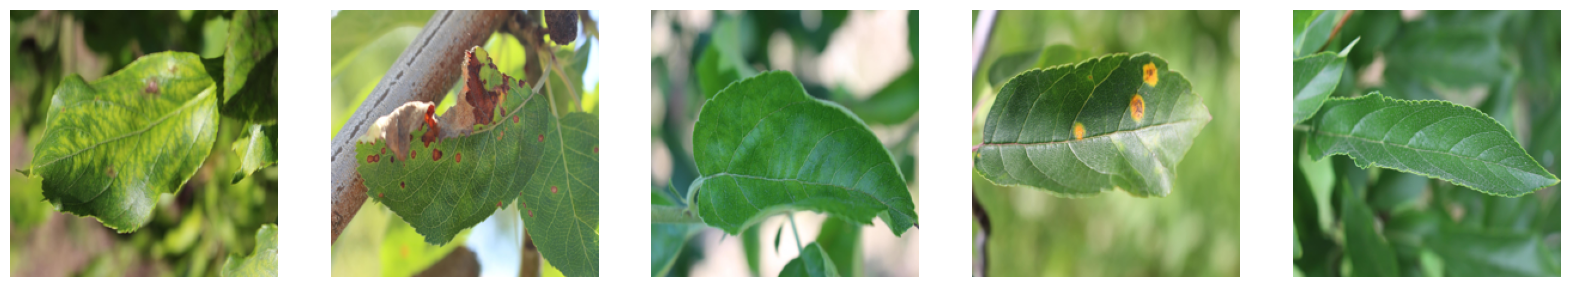

In [11]:
plotImages(images[:5] / 255)

In [12]:
labels = train_data.drop(columns=['image_id'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, np.array(labels.values), test_size=0.20, random_state=42)

In [14]:
sm = SMOTE(random_state=42)

In [15]:
X_train, y_train = sm.fit_resample(X_train.reshape((-1, new_height * new_width * 3)), y_train)

In [16]:
X_train = X_train.reshape((-1, new_height, new_width, 3))

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=45, width_shift_range=0.25,
    height_shift_range=0.25, shear_range=0.5, 
    zoom_range=0.25,horizontal_flip=True, vertical_flip=True, brightness_range=[0.5, 1.5],
    fill_mode="nearest", rescale=1./255)
train_datagen.fit(X_train)

In [18]:
test_datagen = ImageDataGenerator(
    rotation_range=45, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, vertical_flip=True, brightness_range=[0.5, 1.5],
    fill_mode="nearest", rescale=1./255)
test_datagen.fit(X_test)

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation ='relu', padding = 'same', input_shape = images.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation ='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation ='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation ='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation ='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation ='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation ='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation ='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(4, activation = "softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                        

In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            patience=5,
                            verbose=1)

In [22]:
ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=10)

In [23]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32), 
                    steps_per_epoch=X_train.shape[0] // 32,
                    epochs=400, 
                    validation_data=test_datagen.flow(X_test, y_test, batch_size=32),
                    validation_steps=X_test.shape[0] // 32, callbacks=[ES_monitor,LR_reduce])

Epoch 1/400
62/62 [==============================] - 49s 554ms/step - loss: 2.0273 - accuracy: 0.3608 - val_loss: 2.6710 - val_accuracy: 0.2898 - lr: 0.0010
Epoch 2/400
62/62 [==============================] - 34s 543ms/step - loss: 1.3004 - accuracy: 0.4079 - val_loss: 2.7730 - val_accuracy: 0.0483 - lr: 0.0010
Epoch 3/400
62/62 [==============================] - 33s 539ms/step - loss: 1.3005 - accuracy: 0.4200 - val_loss: 3.5912 - val_accuracy: 0.0483 - lr: 0.0010
Epoch 4/400
62/62 [==============================] - 33s 540ms/step - loss: 1.2566 - accuracy: 0.4413 - val_loss: 3.1805 - val_accuracy: 0.0511 - lr: 0.0010
Epoch 5/400
62/62 [==============================] - 34s 547ms/step - loss: 1.2432 - accuracy: 0.4448 - val_loss: 4.7556 - val_accuracy: 0.0511 - lr: 0.0010
Epoch 6/400
62/62 [==============================] - ETA: 0s - loss: 1.1667 - accuracy: 0.4975
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
62/62 [==============================] - 33

In [24]:
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test, batch_size=32), 
                                     steps=X_test.shape[0] // 32)

# Print the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


11/11 [==============================] - 4s 389ms/step - loss: 0.2031 - accuracy: 0.9403
Test loss: 0.2030603438615799
Test accuracy: 0.9403409361839294


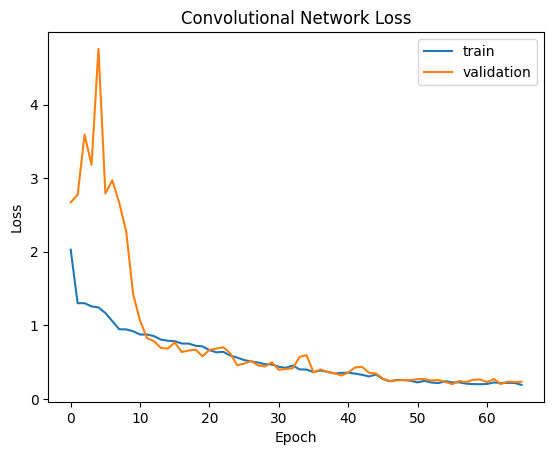

In [25]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Convolutional Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

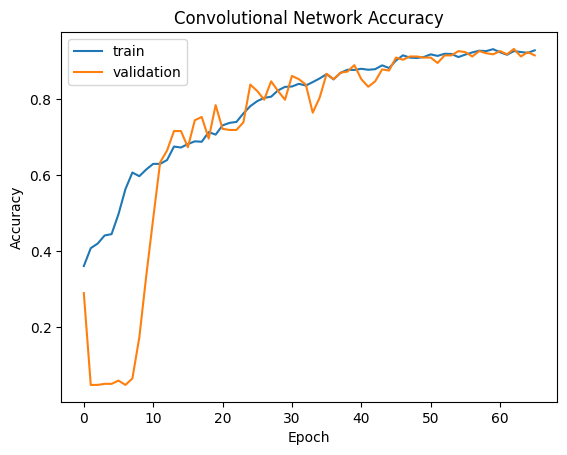

In [26]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Convolutional Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()